In [5]:
import pandas as pd
import seaborn as sns

# Introduction
* In Data Processing, it is often necessary to perform operations on a certain row or column to obtain new data. Instead of writing
```
df = pd.read_csv('data.csv')
df = df.fillna(...)
df = df.query('some_condition')
df['new_column'] = df.cut(...)
df = df.pivot_table(...)
df = df.rename(...)
```
* we can instead do
   ```
   (pd.read_csv('data.csv')
   .fillna(...)
   .query('some_condition')
   .assign(new_column = df.cut(...))
   .pivot_table(...)
   .rename(...)
    )
   
   ```
   
   
* method chaining has always been available in pandas but support for it has increased with new 'chain-able' methods
    * e.g. `query(), assign(), pivot_table()` and in particular `pipe()`

# Dataset Prep

In [2]:
# import titanic dataset

df = pd.read_csv('titanic dataset/train.csv')

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## First check for missing values
* we can use seaborn to create a heatmap to see where they are

<AxesSubplot:>

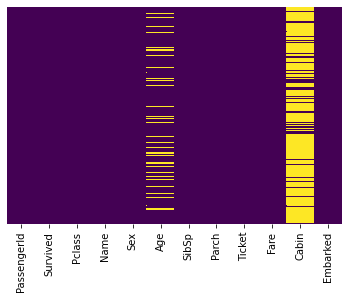

In [9]:
sns.heatmap(df.isnull(),
           yticklabels=False,
           cbar=False,
           cmap='viridis',
            )

* so we can see age and cabin have missing values

# Task
* Suppose we have been asked to take a look at passengers departed from Southampton, and work out the survival rate for different age groups and Pclass.
* Let's first break this task down into discrete steps

1. Data cleaning
    * replace missing Age values (imputation using mean?)
2. Select passengers departed from Southhampton
3. Covnvert ages to groups of age ranges
    * binning
    * <= 12 | teen | <=18 | adult | <= 60 |older |
    
4. Create a pivot table to display the survival rate according to the age grpups and Pclass
5. Improve the display of pivot table by renaming axis labels and formatting values

## 1. Replacing the missing Age with some form of imputation
* So we need to replace missing Age values with some form of imputation
* one way to do so is by using the mean age of all the passages
* let's check them first

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

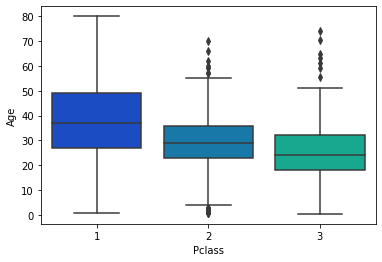

In [10]:
sns.boxplot(x='Pclass', y='Age',data=df,palette='winter')

### Notes
* wealthier passengers (pclass=1) tend to be older
* let's get the mean from these values and use them for imputation

In [15]:
df.groupby('Pclass').mean()

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


In [16]:
pclass_age_map = {
  1: 38,
  2: 30,
  3: 25,
}

## using a bespoke function
def replace_age_na(x_df, fill_map):
    cond=x_df['Age'].isna()
    res=x_df.loc[cond,'Pclass'].map(fill_map)
    x_df.loc[cond,'Age']=res
    return x_df

### Notes

* `x_df['Age'].isna()` selects the Age column and detects the missing values. 
* Then, `x_df.loc[cond, 'Pclass']` is used to access Pclass values conditionally and call Pandas `map()` for substituting each value with another value. 
* Finally, `x_df.loc[cond, 'Age']=res` conditionally replace all missing Age values with res.

In [18]:
## use this to see how the missing ages are replaced
res = (
  pd.read_csv('titanic dataset/train.csv')
    .pipe(replace_age_na, pclass_age_map)
)
res.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<AxesSubplot:>

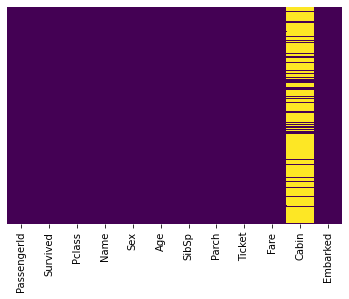

In [19]:
sns.heatmap(res.isnull(), 
            yticklabels=False, 
            cbar=False, 
            cmap='viridis')

## 2. Select passengers departed from Southampton
* if they embarked from southampton, the embarked value will be `s`
* we can select those entries with the `query()` function

In [20]:
res = (
    pd.read_csv('titanic dataset/train.csv')
    .pipe(replace_age_na, pclass_age_map)
    .query('Embarked == "S"')
)
res.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S


In [21]:
## evaluate the query result

res.Embarked.value_counts()

S    644
Name: Embarked, dtype: int64

##  3. Convert ages to groups of age ranges: ≤12, Teen (≤ 18), Adult (≤ 60) and Older (>60)
* we can use the pandas built-in `assign()` function to add new columns to a dataframe

In [23]:
bins = [0,13,19,61,100]
labels = ['<12','Teen','Adult','Older']

res = (
  pd.read_csv('titanic dataset/train.csv')
    .pipe(replace_age_na, pclass_age_map)
    .query('Embarked == "S"')
    .assign(ageGroup = lambda df: pd.cut(df['Age'], bins=bins, labels=labels))
)
res.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,ageGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Adult
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Adult


### pandas.cut

* Bin values into discrete intervals.

* Use cut when you need to segment and sort data values into bins. This function is also useful for going from a continuous variable to a categorical variable. For example, cut could convert ages to groups of age ranges. Supports binning into an equal number of bins, or a pre-specified array of bins.

* `pandas.cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False, duplicates='raise', ordered=True)`

* x: array-like, must be 1-dimensional
* bins: int, sequence of scalars
    * int : Defines the number of equal-width bins in the range of x. The range of x is extended by .1% on each side to include the minimum and maximum values of x.
 
## 4. Create a pivot table to display the survival rate for different age groups and Pclass
* A pivot table allows us to insights into our data. Let’s figure out the survival rate with it.


In [26]:
bins=[0, 13, 19, 61, 150]
labels=['<12', 'Teen', 'Adult', 'Older']
(
  pd.read_csv('titanic dataset/train.csv')
    .pipe(replace_age_na, pclass_age_map)
    .query('Embarked == "S"')
    .assign(ageGroup = lambda df: pd.cut(df['Age'], bins=bins, labels=labels))
    .pivot_table(
        values='Survived', 
        columns='Pclass', 
        index='ageGroup', 
        aggfunc='mean')
)

Pclass,1,2,3
ageGroup,,,
<12,0.750000,1.000000,0.371429
Teen,0.800000,0.400000,0.177778
Adult,0.580952,0.407692,0.166052
Older,0.250000,0.333333,0.500000


* The first parameter values='Survived' specifies the column Survived to aggregate. 
* Since the value of Survived is 1 or 0, we can use the aggregation function mean to calculate the survival rate and therefore aggfunc='mean' is used. index='ageGroup' and columns='Pclass' will display ageGroup as rows and Pclass as columns in the output table.